In [70]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import NaN
import numpy as np

sns.set_style("white")

% matplotlib inline

## Load and clean data

In [2]:
df = pd.read_csv('burgers.csv', encoding='utf-8').fillna(0)

In [3]:
df.columns = [name.strip().lower() for name in df.columns]

Some of the descriptions got all weird and duplicated in one of the spreadsheets, so I gotta fix it.

In [4]:
def snip(text):
    index = text[20:].find(text[:20])
    if index > 0:
        return text[:index+20]
    else:
        return text
    
df['burger description'] = df['burger description'].apply(snip)

In [5]:
df[df.columns[-12:]] = df[df.columns[-12:]].replace({'Yes': 1})

In [6]:
df['price'] = df.price.astype(str).apply(lambda x: float(x.replace('$','')))

In [7]:
df['other'] = df[[u'duck', u'sweet', u'venison', u'vegetarian', u'not your usual']].sum(axis=1)

## Some Descriptive Stats

In [8]:
len(df)

555

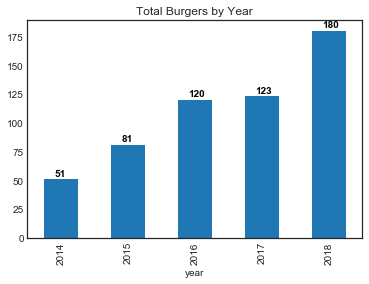

In [9]:
vals = df.groupby('year')['restaurant'].count()

fig = vals.plot(kind='bar')
plt.title('Total Burgers by Year')

for i, value in enumerate(vals.values):
    fig.text(i-0.1, value + 3, str(value), color='black', fontweight='bold')

plt.savefig('totals_by_year.png', bbox_inches='tight')

In [10]:
df.groupby('finalist').agg({'restaurant':'count', 'price': 'mean'})

price  restaurant
finalist                       
0         20.749531         533
1         21.181818          22

## Charts

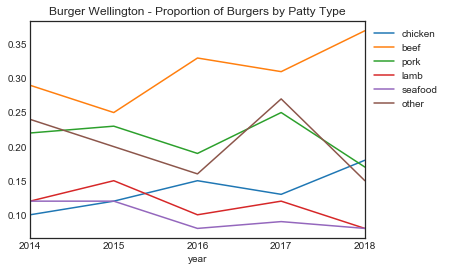

In [11]:
cols = ['chicken', 'beef', 'pork', 'lamb', u'seafood', 'other']

(df.groupby('year')[cols].sum()\
         /df.groupby('year')[cols].count()).round(2)\
        .plot()
plt.title('Burger Wellington - Proportion of Burgers by Patty Type')
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks([year for year in range(2014, 2019)])
plt.savefig('patties.png', bbox_inches='tight')

In [12]:
(df.groupby('year')[cols].sum()/df.groupby('year')[cols].count()).round(2)

chicken  beef  pork  lamb  seafood  other
year                                           
2014     0.10  0.29  0.22  0.12     0.12   0.24
2015     0.12  0.25  0.23  0.15     0.12   0.20
2016     0.15  0.33  0.19  0.10     0.08   0.16
2017     0.13  0.31  0.25  0.12     0.09   0.27
2018     0.18  0.37  0.17  0.08     0.08   0.15

In [13]:
year_counts = df.groupby('year')['burger description'].count().values
years = [str(year) for year in range(2014, 2019)]

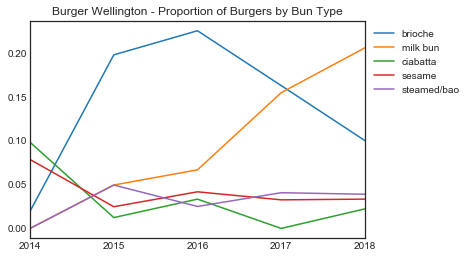

In [14]:

buns = ['brioche', 'milk bun', 'bao', 'steamed bun', 'ciabatta', 'sesame']
bun_counts = [df['burger description'].str.contains(bun).groupby(df.year).sum().values for bun in buns]
bun_totals = df['burger description'].str.contains(' bun').groupby(df.year).sum().values

bun_df = (pd.DataFrame(bun_counts, index=buns, columns=years).transpose()).div(year_counts, axis=0)
bun_df['steamed/bao'] = bun_df['bao'] + bun_df['steamed bun']
bun_df = bun_df[[c for c in bun_df.columns if c not in ['steamed bun', 'bao']]]

bun_df.plot()
plt.title('Burger Wellington - Proportion of Burgers by Bun Type')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('buns.png', bbox_inches='tight')

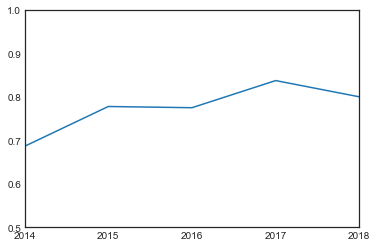

In [15]:
pd.DataFrame((bun_totals / year_counts), index=range(2014, 2019)).plot()
plt.xticks([year for year in range(2014, 2019)])
plt.legend('')
plt.ylim(0.5, 1)
plt.show()

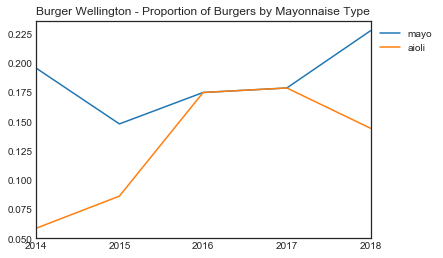

In [16]:
mayos =  ['mayo', 'aioli']
mayo_counts = [df['burger description'].str.contains(mayo).groupby(df.year).sum().values for mayo in mayos]
mayo_df = (pd.DataFrame(mayo_counts, index=mayos, columns=years).transpose()).div(year_counts, axis=0)
mayo_df.plot()
plt.title('Burger Wellington - Proportion of Burgers by Mayonnaise Type')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('mayo.png', bbox_inches='tight')

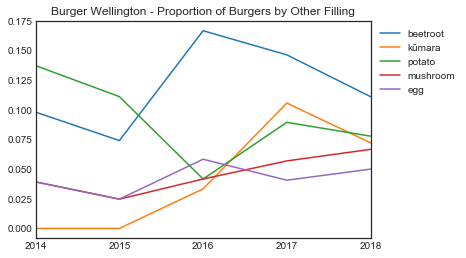

In [17]:
others =  ['beetroot', u'kūmara', 'potato', 'mushroom', 'egg']
counts = [df['burger description'].str.contains(thing).groupby(df.year).sum().values for thing in others]
other_df = (pd.DataFrame(counts, index=others, columns=years).transpose()).div(year_counts, axis=0)
other_df.plot()
plt.title('Burger Wellington - Proportion of Burgers by Other Filling')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

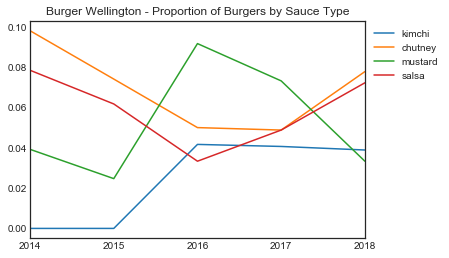

In [18]:
others =  ['kimchi', u'chutney', 'mustard', 'salsa']
counts = [df['burger description'].str.contains(thing).groupby(df.year).sum().values for thing in others]
other_df = (pd.DataFrame(counts, index=others, columns=years).transpose()).div(year_counts, axis=0)
other_df.plot()
plt.title('Burger Wellington - Proportion of Burgers by Sauce Type')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## Pull out ingredients

In [55]:
from nltk import word_tokenize, pos_tag, RegexpParser
from sklearn.feature_extraction.text import CountVectorizer

We define a "grammar" which is a regex-like pattern for identifying noun-phrases. This one means something like "Any number of contiguous nouns, plural nouns, or adjectives".

In [46]:
grammar = ('''
    NP: {(<NN>|<NNS>|<JJ>)*}
    ''')

chunker = RegexpParser(grammar)

Then we can define a method which does a tiny bit of cleaning, then tags the text and identifies noun phrases.

In [47]:
def noun_phrases(text, chunker=chunker):
    text = text.replace("'", '')
    parsed = chunker.parse(pos_tag(word_tokenize(text)))
    return [' '.join([i[0] for i in subtree.leaves()]) for subtree in parsed.subtrees() if subtree.label() == 'NP']

Here's an example of how it works:

In [50]:
text = df['burger description'][10]
text

u'Two custom blended beef patties" with three-cheese fondue, iceberg, bacon jam, pickles and onion rings in a \'milk\' bun, with cheese-fondue curly fries.'

In [51]:
noun_phrases(text)

[u'custom',
 u'beef patties',
 u'three-cheese fondue',
 u'iceberg',
 u'bacon jam',
 u'pickles',
 u'onion rings',
 u'milk bun',
 u'cheese-fondue curly fries']

A cool thing is that we can pass that method straight to a Count Vectorizer object, to create a bag-of-words dataframe - a table with a column for each noun phrase and a row for each burger.

In [52]:
countvec = CountVectorizer(tokenizer=noun_phrases)
nouns = countvec.fit_transform(df['burger description'])
nouns_df = pd.DataFrame(nouns.toarray(), columns=countvec.get_feature_names())

## Picking Winners

We're going to calculate the "Uniqueness" of each ingredient, and then see if finalist burgers are more unique than non-finalists.

In [59]:
uniqueness_index = (nouns_df * nouns_df.sum()).replace(0, NaN).mean(axis=1)

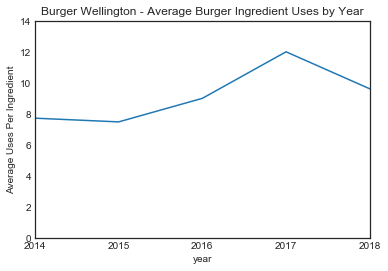

In [76]:
uniqueness_index.groupby(df.year).mean().plot()
plt.xticks([year for year in range(2014, 2019)])
plt.ylim(0, 14)
plt.title('Burger Wellington - Average Burger Ingredient Uses by Year')
plt.ylabel('Average Uses Per Ingredient')
plt.savefig('uniqueness_by_year.png')

In [60]:
actual = uniqueness_index.groupby(df.finalist).mean()

The observed difference in the dataset is -3.9. In other words, the ingredients in finalist burgers were, on average, used in 60% fewer other burgers, or four burgers on averge.

In [69]:
actual[1] / actual[0]

0.59913051535139727

We can use a quick-and-dirty Bayesian technique to measure significance. We randomly shuffle the data and measure the difference each time. If the difference is significant, we should see the observed difference fall well outside the bell-curve of the random differences.

In [71]:
differences = []
for i in range(5000):
    randoms = np.random.rand(len(uniqueness_index)) <= 22/555.0
    grouped = uniqueness_index.groupby(randoms).mean()
    differences.append(grouped[0] - grouped[1])

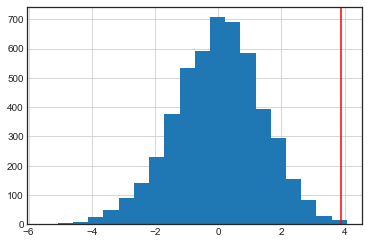

In [72]:
pd.Series(differences).hist(bins=20)
plt.axvline(x=actual[0]-actual[1], c='r')
plt.show()

Another way to visualise this is to look at the proportion of random results that were less than the observed difference:

In [74]:
from math import floor

(pd.Series([floor(abs(i)) for i in differences]).value_counts()/len(differences)).cumsum()

0.0    0.5348
1.0    0.8506
2.0    0.9696
3.0    0.9964
4.0    0.9998
5.0    1.0000
dtype: float64

In [75]:
(np.array(differences) > actual[0]-actual[1]).sum()/5000.0

0.00080000000000000004

## Typical Burgers by Year

Here's my nasty and uncientific way of doing this:

In [78]:
total = nouns_df.sum()[nouns_df.sum()>=5]
year = nouns_df.groupby(df.year).sum().loc[2018][nouns_df.sum()>=5]
(year/total).sort_values(ascending=False)

zaidas bakery milk bun             1.000000
swiss cheese                       0.833333
mayo                               0.750000
pandoro milk bun                   0.714286
housemade bun                      0.666667
salad                              0.636364
kimchi                             0.625000
bread                              0.600000
bbq sauce                          0.600000
bacon patty                        0.600000
chipotle mayo                      0.600000
chutney                            0.600000
prosciutto                         0.600000
mango                              0.571429
slaw                               0.550000
gravy                              0.545455
chicken                            0.520000
mint                               0.500000
milk bun                           0.500000
chorizo                            0.500000
lamb patty                         0.500000
fix                                0.500000
apple slaw                      